<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/04-transfer-learning/03_residual_connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer Learning: Residual Connections

Now, let's consider what is Transfer learning?

The idea is quite simple. First, some big tech company, which has access to virtually
infinite amounts of data and computing power, develops and trains a huge model
for their own purpose. 

Next, once it is trained, its architecture and the corresponding trained weights (the pre-trained model) are released. Finally,
everyone else can use these weights as a starting point and fine-tune them
further for a different (but similar) purpose.

That’s transfer learning in a nutshell.

##Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter7()
# This is needed to render the plots in this chapter
from plots.chapter7 import *

Finished!


In [3]:
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
#from torchvision.models.alexnet import model_urls
try:
  from torchvision.models.utils import load_state_dict_from_url
except ImportError:
  from torch.hub import load_state_dict_from_url

from stepbystep.v3 import StepByStep
from data_generation.rps import download_rps

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [18]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

unzip -qq rock-paper-scissors-dataset.zip
rm -rf rock-paper-scissors-dataset.zip

 97% 439M/452M [00:09<00:00, 62.4MB/s]
100% 452M/452M [00:09<00:00, 50.9MB/s]


## Data Preparation

The data preparation step will be a bit more demanding this time since we’ll be
standardizing the images.Besides, we can use the ImageFolder dataset now.

The Rock Paper Scissors dataset is organized like that:

```
rps/paper/paper01-000.png
rps/paper/paper01-001.png

rps/rock/rock01-000.png
rps/rock/rock01-001.png

rps/scissors/scissors01-000.png
rps/scissors/scissors01-001.png
```

The dataset is also perfectly balanced, with each sub-folder containing 840 images
of its particular class.

In [19]:
ROOT_FOLDER = "Rock-Paper-Scissors"

Since we’re using a pre-trained model, we need to use the standardization
parameters used to train the original model. 

In other words, we need to use the
statistics of the original dataset used to train that model.

So, the data preparation step for the Rock Paper Scissors dataset looks like this now:

In [20]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
composer = Compose([
  Resize(256),
  CenterCrop(224),
  ToTensor(),
  normalizer
])

train_data = ImageFolder(root=f"{ROOT_FOLDER}/train", transform=composer)
val_data = ImageFolder(root=f"{ROOT_FOLDER}/test", transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

##Residual Connections

The idea of a residual connection is quite simple, actually: After passing the input
through a layer and activation function, the input itself is added to the result.

Why would I want to add the input to the result?



###Learning the Identity

Neural networks and their nonlinearities (activation functions) are great!

But nonlinearities are both a blessing and a curse: They
make it extremely hard for a model to learn the identity function.

To illustrate this, let’s start with a dummy dataset containing 100 random data
points with a single feature. 

But this feature isn’t simply a feature—it is also the
label.

In [4]:
torch.manual_seed(23)

dummy_points = torch.randn((100, 1))

dummy_dataset = TensorDataset(dummy_points, dummy_points)
dummy_loader = DataLoader(dummy_dataset, batch_size=16, shuffle=True)

If we were using a simple linear model, that would be a no-brainer, right?

But what happens if we introduce a nonlinearity? 

Let’s
configure the model and train it to see what happens:

In [5]:
class Dummy(nn.Module):
  def __init__(self):
    super(Dummy, self).__init__()

    self.linear = nn.Linear(1, 1)
    self.activation = nn.ReLU()

  def forward(self, x):
    output = self.linear(x)
    output = self.activation(output)
    return output

In [6]:
torch.manual_seed(555)

dummy_model = Dummy()
dummy_loss_fn = nn.MSELoss()
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.1)

In [7]:
dummy_sbs = StepByStep(dummy_model, dummy_loss_fn, dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(200)

If we compare the actual labels with the model’s predictions, we’ll see that it failed
to learn the identity function:

In [8]:
np.concatenate([
  dummy_points[:5].numpy(),
  dummy_sbs.predict(dummy_points)[:5]
], axis=1)

array([[-0.9012059 ,  0.        ],
       [ 0.56559485,  0.56559485],
       [-0.48822638,  0.        ],
       [ 0.75069577,  0.7506957 ],
       [ 0.58925384,  0.58925384]], dtype=float32)

Since the `ReLU` can only return positive values, it will
never be able to produce the points with negative values.

Wait, that doesn’t look right … where is the output layer?

I suppressed the output layer on purpose to make a point here.

Please bear with me a little bit longer while I add a residual connection to the
model:

In [9]:
class DummyResidual(nn.Module):
  def __init__(self):
    super(DummyResidual, self).__init__()

    self.linear = nn.Linear(1, 1)
    self.activation = nn.ReLU()

  def forward(self, x):
    identity = x
    output = self.linear(x)
    output = self.activation(output)
    output = output + identity
    return output

In [10]:
torch.manual_seed(555)

dummy_model = DummyResidual()
dummy_loss_fn = nn.MSELoss()
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.1)

In [11]:
dummy_sbs = StepByStep(dummy_model, dummy_loss_fn, dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(100)

Let’s double-check it.

In [12]:
np.concatenate([
  dummy_points[:5].numpy(),
  dummy_sbs.predict(dummy_points)[:5]
], axis=1)

array([[-0.9012059 , -0.9012059 ],
       [ 0.56559485,  0.56559485],
       [-0.48822638, -0.48822638],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

It looks like the model actually learned the identity function … or did it? 

Let’s check its parameters:

In [13]:
dummy_model.state_dict()

OrderedDict([('linear.weight', tensor([[0.1490]])),
             ('linear.bias', tensor([-0.3329]))])

For an input value equal to zero, the output of the linear layer will be -0.3326,
which, in turn, will be chopped off by the ReLU activation.Then 

Which input values produce outputs greater than zero?

The answer: Input values above `2.2352 (=0.3326/0.1488)` will produce positive
outputs, which, in turn, will pass through the ReLU activation. 

But I have another question for you:

Guess what is the highest input value in our dataset?



In [14]:
dummy_points.max()

tensor(2.2347)

So what? Does it actually mean anything?

It means the model learned to stay out of the way of the inputs! 

Now that the
model has the ability to use the raw inputs directly, its linear layer learned to
produce only negative values, so its nonlinearity (ReLU) produces only zeros.

###Residual Blocks

The residual connection works as a shortcut, enabling the model
to skip the nonlinearities when it pays off to do so (if it yields a
lower loss). 

For this reason, **residual connections are also known
as skip connections**.

The big deal is, these shortcuts make the loss surface smoother, so gradient
descent has an easier job finding a minimum.

Another advantage of these shortcuts is that they provide a
shorter path for the gradients to travel back to the initial layers,
thus preventing the vanishing gradients problem.

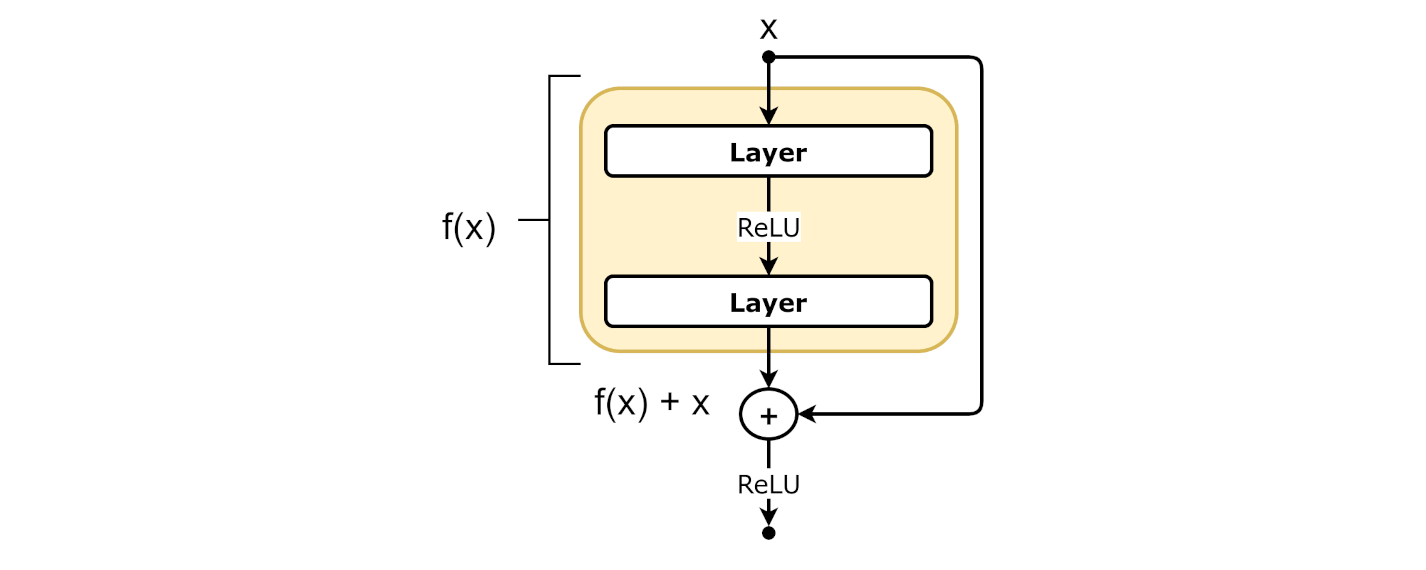

In [15]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, skip=True):
    super(ResidualBlock, self).__init__()

    self.skip = skip

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
    self.batch_norm1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.batch_norm2 = nn.BatchNorm2d(out_channels)
    
    self.downsample = None
    if out_channels != in_channels:
      self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

  def forward(self, x):
    identity = x
    output = self.conv1(x)
    output = self.batch_norm1(output)
    output = self.relu(output)

    output = self.conv2(x)
    output = self.batch_norm2(output)

    if self.skip:
      if self.downsample is not None:
        identity = self.downsample(identity)
      output += identity

    output = self.relu(output)
    return output

It should be pretty clear, except for one small detail: It may be necessary to
downsample the input.

To add up two images, they must have the same dimensions—not only the height
and the width, but also the number of channels (adding up is not the same as
stacking up channels!). 

That poses a problem for the residual block, since the
number of output channels of the last convolutional layer may be different than
the number of channels in the input.


Finally, to illustrate the effect of the skip connection on an image, I’ve passed one of
the images from the Rock Paper Scissors dataset through a randomly initialized
residual block (three channels in and out, no downsampling), with and without a
skip connection.

In [21]:
seed = 14

scissors = Image.open(f"{ROOT_FOLDER}/train/scissors/scissors01-001.png")

image = ToTensor()(scissors)[:3, :, :].view(1, 3, 300, 300)

torch.manual_seed(seed)
skip_image = ResidualBlock(3, 3)(image)
skip_image = ToPILImage()(skip_image[0])

torch.manual_seed(seed)
noskip_image = ResidualBlock(3, 3, skip=False)(image)
noskip_image = ToPILImage()(noskip_image[0])

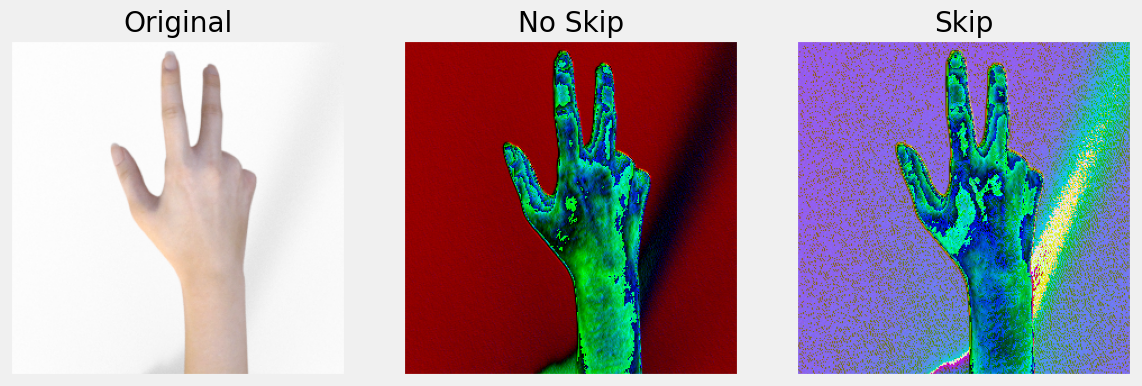

In [22]:
fig = compare_skip(scissors, noskip_image, skip_image)

On the one hand, if there are no skip connections, some
information may be lost, like the different shades on the back of the hand. On the
other hand (sorry!), skip connections may help to preserve that information.

That’s the general idea behind the ResNet model.